# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lecture 10 Additional Code: Multiple and Polynomial Regression (September 26, 2019 version) 

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Lab Instructor:** Chris Tanner and Eleni Kaxiras<br/>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Table of Contents

<ol start="0">
<li> Learning Goals / Tip of the Week / Terminology </li>
<li> Training/Validation/Testing Splits (slides + interactive warm-up)</li>
<li> Polynomial Regression, and Revisiting the Cab Data</li>
<li> Multiple regression and exploring the Football data </li>
<li> A nice trick for forward-backwards </li>
</ol>

## Learning Goals
After this lab, you should be able to
- Explain the difference between train/validation/test data and WHY we have each.
- Implement cross-validation on a dataset
- Implement arbitrary multiple regression models in both SK-learn and Statsmodels.
- Interpret the coefficent estimates produced by each model, including transformed and dummy variables

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Extra Tip of the Week

Within your terminal (aka console aka command prompt), most shell environments support useful shortcuts:

<ul>
  <li>press the [up arrow] to navigate through your most recent commands</li>
  <li>press [CTRL + A] to go to the beginning of the line</li>
  <li>press [CTRL + E] to go to the end of the line</li>
  <li>press [CTRL + K] to clear the line</li>
  <li>type `history` to see the last commands you've run</li>
</ul>  


## Terminology

Say we have input features $X$, which via some function $f()$, approximates outputs $Y$. That is, $Y = f(X) + \epsilon$ (where $\epsilon$ represents our unmeasurable variation (i.e., irreducible error).

- **Inference**: estimates the function $f$, but the goal isn't to make predictions for $Y$; rather, it is more concerned with understanding the relationship between $X$ and $Y$.
- **Prediction**: estimates the function $f$ with the goal of making accurate $Y$ predictions for some unseen $X$.


We have recently used two highly popular, useful libraries, `statsmodels` and `sklearn`.

`statsmodels` is mostly focused on the _inference_ task. It aims to make good estimates for $f()$ (via solving for our $\beta$'s), and it provides expansive details about its certainty. It provides lots of tools to discuss confidence, but isn't great at dealing with test sets.

`sklearn` is mostly focused on the _prediction_ task. It aims to make a well-fit line to our input data $X$, so as to make good $Y$ predictions for some unseen inputs $X$. It provides a shallower analysis of our variables. In other words, `sklearn` is great at test sets and validations, but it can't really discuss uncertainty in the parameters or predictions.


- **R-squared**: An interpretable summary of how well the model did. 1 is perfect, 0 is a trivial baseline model based on the mean $y$ value, and negative is worse than the trivial model.
- **F-statistic**: A value testing whether we're likely to see these results (or even stronger ones) if none of the predictors actually mattered.
- **Prob (F-statistic)**: The probability that we'd see these results (or even stronger ones) if none of the predictors actually mattered. If this probability is small then either A) some combination of predictors actually matters or B) something rather unlikely has happened
- **coef**: The estimate of each beta. This has several sub-components:
  - **std err**: The amount we'd expect this value to wiggle if we re-did the data collection and re-ran our model. More data tends to make this wiggle smaller, but sometimes the collected data just isn't enough to pin down a particular value.
  - **t and P>|t|**: similar to the F-statistic, these measure the probability of seeing coefficients this big (or even bigger) if the given variable didn't actually matter. Small probability doesn't necessarily mean the value matters
  - **\[0.025 0.975\]**: Endpoints of the 95% confidence interval. This is a interval drawn in a clever way and which gives an idea of where the true beta value might plausibly live. (If you want to understand why "there's a 95% chance the true beta is in the interval" is _wrong_, start a chat with Will : )
  

## Part 2: Polynomial Regression, and Revisiting the Cab Data

Polynomial regression uses a **linear model** to estimate a **non-linear function** (i.e., a function with polynomial terms). For example:

$y = \beta_0 + \beta_1x_i + \beta_1x_i^{2}$

It is a linear model because we are still solving a linear equation (the _linear_ aspect refers to the beta coefficients).

In [4]:
# read in the data, break into train and test
cab_df = pd.read_csv("data/cab_dataset.txt")
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [5]:
cab_df.shape

(1250, 2)

In [6]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60 # transforms it to being hour-based
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60 # hour-based
y_test = test_data['PickupCount'].values

def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # optionally use the passed-in transformer
    if poly_transformer != None:
        dm = poly_transformer.fit_transform(x_vals)
    else:
        dm = x_vals
        
    # make the prediction at each x value
    prediction = cur_model.predict(dm)
    
    # plot the prediction line, and the test data
    plt.plot(x_vals,prediction, color='k', label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # label your plots
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show()

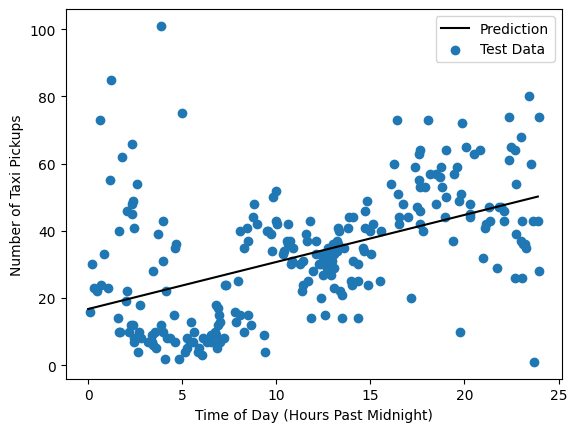

In [7]:
from sklearn.linear_model import LinearRegression
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

In [8]:
fitted_cab_model0.score(X_test, y_test)

0.240661535615741

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. The above code uses `sklearn`. As more practice, and to help you stay versed in both libraries, perform the same task (fit a linear regression line) using `statsmodels` and report the $r^2$ score. Is it the same value as what sklearn reports, and is this the expected behavior?

*both sklearn and statsmodels should provide the same R-squared value for the same dataset and model specifications. This is expected behavior because the R-squared metric is a standardized measure of how well the model explains the variance in the dependent variable.*

In [9]:
### SOLUTION:

# augment the data with a column vector of 1's
train_data_augmented = sm.add_constant(X_train)
test_data_augmented = sm.add_constant(X_test)

# fit the model on the training data
OLSModel = OLS(train_data['PickupCount'].values, train_data_augmented).fit()

# get the prediction results
ols_predicted_pickups_test = OLSModel.predict(test_data_augmented)
r2_score_test = r2_score(test_data[['PickupCount']].values, ols_predicted_pickups_test)
print(r2_score_test)

0.240661535615741


We can see that there's still a lot of variation in cab pickups that's not being captured by a linear fit. Further, the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. This is a bad property, and it's the conseqeuence of having a straight line with a non-zero slope. However, we can add columns to our data for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a curvy polynomial line to hopefully fit the data better.

We'll be using ``sklearn``'s `PolynomialFeatures()` function to take some of the tedium out of building the expanded input data. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$, it will directly return a new copy of the data in this format!

In [13]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
expanded_train = transformer_3.fit_transform(X_train) # TRANSFORMS it to polynomial features
print(expanded_train[:5])
pd.DataFrame(expanded_train).describe() # notice that the columns now contain x, x^2, x^3 values

[[6.73333333e+00 4.53377778e+01 3.05274370e+02]
 [2.18333333e+00 4.76694444e+00 1.04078287e+01]
 [1.41666667e+00 2.00694444e+00 2.84317130e+00]
 [8.98333333e+00 8.07002778e+01 7.24957495e+02]
 [2.11000000e+01 4.45210000e+02 9.39393100e+03]]


,0,1,2
count,1000.000000,1000.000000,1000.000000
mean,11.717217,182.833724,3234.000239
std,6.751751,167.225711,3801.801966
min,0.066667,0.004444,0.000296
25%,6.100000,37.210833,226.996222
50%,11.375000,129.390694,1471.820729
75%,17.437500,304.066458,5302.160684
max,23.966667,574.401111,13766.479963


A few notes on `PolynomialFeatures`:

- The interface is a bit strange. `PolynomialFeatures` is a _'transformer'_ in sklearn. We'll be using several transformers that learn a transformation on the training data, and then we will apply those transformations on future data. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above with ``.fit_transform()`.
- You rarely want to `include_bias` (a column of all 1's), since _**sklearn**_ will add it automatically. Remember, when using _**statsmodels,**_ you can just `.add_constant()` right before you fit the data.
- If you want polynomial features for a several different variables (i.e., multinomial regression), you should call `.fit_transform()` separately on each column and append all the results to a copy of the data (unless you also want interaction terms between the newly-created features). See `np.concatenate()` for joining arrays.

fitting expanded_train: [[6.73333333e+00 4.53377778e+01 3.05274370e+02]
 [2.18333333e+00 4.76694444e+00 1.04078287e+01]
 [1.41666667e+00 2.00694444e+00 2.84317130e+00]
 ...
 [1.96666667e+01 3.86777778e+02 7.60662963e+03]
 [1.17333333e+01 1.37671111e+02 1.61534104e+03]
 [1.42000000e+01 2.01640000e+02 2.86328800e+03]]


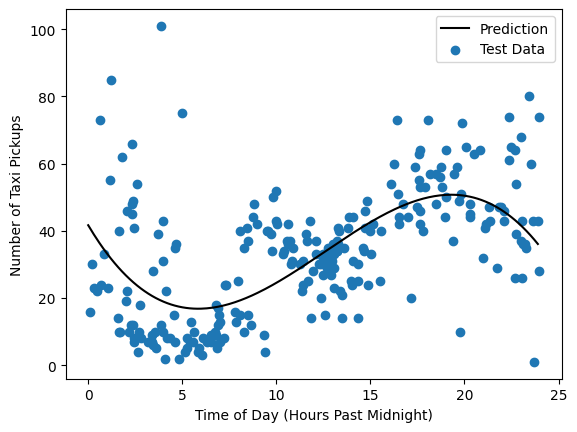

In [16]:
# EXAMPLE POLINOMAL FEATURES FOR SEVERAL VARIABLES
# Sample data with two variables
#   X = np.array([[1, 2], [3, 4], [5, 6]])

# Instantiate PolynomialFeatures separately for each variable
#   poly_features_X1 = PolynomialFeatures(degree=2, include_bias=False)
#   poly_features_X2 = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform each variable separately
#   X1_poly = poly_features_X1.fit_transform(X[:, 0].reshape(-1, 1))
#   X2_poly = poly_features_X2.fit_transform(X[:, 1].reshape(-1, 1))

# Concatenate the results horizontally (axis=1)
#   X_poly = np.concatenate((X1_poly, X2_poly), axis=1)




# Display the original and polynomial features
#   print("Original Data:")
#   print(X)
#   print("\nPolynomial Features:")
#   print(X_poly)
#################################################

#First of transform the original dataset, then you fit the linear regression for future predictions

fitted_cab_model3 = LinearRegression().fit(expanded_train, y_train)
print("fitting expanded_train:", expanded_train)
plot_cabs(fitted_cab_model3, transformer_3)

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. 
2. Does the polynomial model improve on the purely linear model?
3. Make a residual plot for the polynomial model. What does this plot tell us about the model?

In [19]:
# ANSWER 1
expanded_test = transformer_3.fit_transform(X_test)
print("Test R-squared:", fitted_cab_model3.score(expanded_test, y_test))
# NOTE 1: unlike statsmodels' r2_score() function, sklearn has a .score() function
# NOTE 2: fit_transform() is a nifty function that transforms the data, then fits it

Test R-squared: 0.33412512570778774


In [20]:
# ANSWER 2: yes it does.

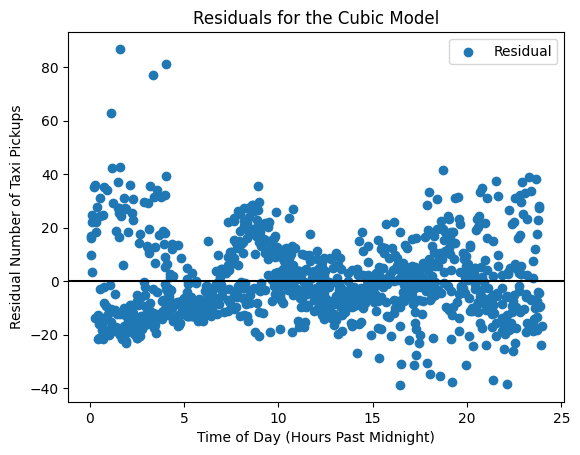

In [20]:
# ANSWER 3 (class discussion about the residuals)
x_matrix = transformer_3.fit_transform(X_train)

prediction = fitted_cab_model3.predict(x_matrix)
residual = y_train - prediction
plt.scatter(X_train, residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the Cubic Model")
plt.ylabel("Residual Number of Taxi Pickups")
plt.xlabel("Time of Day (Hours Past Midnight)")
plt.legend()

**ANSWER 3**
An ideal residual plot would show a random scatter of points around a horizontal line at zero. This would indicate that the model is fitting the data well and there are no systematic errors.

This shows a curving pattern, with residuals increasing then decreasing as time of day increases. This suggests that the cubic model may not be capturing the relationship between time of day and number of taxi pickups very well. There could be a more complex relationship at play that a higher-order polynomial or a different type of model could capture.

#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

### Scaling Features
When using polynomials, we are explicitly trying to use the higher-order values for a given feature. However, sometimes these polynomial features can take on values that are drastically large, making it difficult for the system to learn an appropriate bias weight due to its large values and potentially large variance. To counter this, sometimes one may be interested in scaling the values for a given feature.

For our ongoing taxi-pickup example, using polynomial features improved our model. If we wished to scale the features, we could use `sklearn`'s StandardScaler() function:

In [21]:
# SCALES THE EXPANDED/POLY TRANSFORMED DATA
# we don't need to convert to a pandas dataframe, but it can be useful for scaling select columns
train_copy = pd.DataFrame(expanded_train.copy())
test_copy = pd.DataFrame(expanded_test.copy())

# Fit the scaler on the training data
scaler = StandardScaler().fit(train_copy)

# Scale both the test and training data. 
train_scaled = scaler.transform(expanded_train)
test_scaled = scaler.transform(expanded_test)

# we could optionally run a new regression model on this scaled data
fitted_scaled_cab = LinearRegression().fit(train_scaled, y_train)
fitted_scaled_cab.score(test_scaled, y_test)

0.33412512570778274

<hr style="height:3px">

## Part 3: Multiple regression and exploring the Football (aka soccer) data
Let's move on to a different dataset! The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by https://www.transfermarkt.us.

- `name`: Name of the player 
- `club`: Club of the player 
- `age` : Age of the player
- `position` : The usual position on the pitch
- `position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
- `market_value` : As on www.transfermarkt.us.on July 20th, 2017  
- `page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
- `fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  **missing in the DS**
- `fpl_sel` : % of FPL players who have selected that player in their team   **missing in the DS**
- `fpl_points` : FPL points accumulated over the previous season   
- `region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
- `nationality`: Player's nationality  
- `new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
- `age_cat`: a categorical version of the Age feature  **missing in the DS**
- `club_id`: a numerical version of the Club feature  **missing in the DS**
- `big_club`: Whether one of the Top 6 clubs  **missing in the DS**
- `new_signing`: Whether a new signing for 2017/18 (till 20th July)

As always, we first import, verify, split, and explore the data.

## Part 3.1: Import and verification and grouping

In [25]:
league_df = pd.read_csv("data/league_data.csv")
print(league_df.dtypes)

# QUESTION: what would you guess is the mean age? mean salary?
league_df.head() # turns out, it's a lot

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
club_id           int64
new_signing       int64
dtype: object


,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,264,3.0,Chile,0,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,167,2.0,Germany,0,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,134,2.0,Czech Republic,0,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,122,1.0,England,0,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,121,2.0,France,0,1,0


In [26]:
league_df.shape

(461, 13)

In [27]:
league_df.describe()

,age,position_cat,market_value,page_views,fpl_points,region,new_foreign,club_id,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,57.314534,1.993478,0.034707,10.334056,0.145336
std,3.961892,1.000061,12.257403,931.805757,53.113811,0.957689,0.183236,5.726475,0.352822
min,17.000000,1.000000,0.050000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,5.000000,1.000000,0.000000,6.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,51.000000,2.000000,0.000000,10.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,94.000000,2.000000,0.000000,15.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,264.000000,4.000000,1.000000,20.000000,1.000000


### (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Use the `train_test_split()` function, while (a) ensuring the test size is 20% of the data, and; (2) using 'stratify' argument to split the data (look up documentation online), keeping equal representation of each region. This doesn't work by default, correct? What is the issue?
2. Deal with the issue you encountered above. Hint: you may find numpy's `.isnan()` and panda's `.dropna()` functions useful!
3. How did you deal with the error generated by `train_test_split`? How did you justify your action? 

In [28]:
### SOLUTION:
try:
    
    # Doesn't work: a value is missing
    train_data, test_data = train_test_split(league_df, test_size = 0.2, stratify=league_df['region'])
except:
    
    # Count the missing lines and drop them
    missing_rows = np.isnan(league_df['region'])
    print("Uh oh, {} lines missing data! Dropping them".format(np.sum(missing_rows)))
    league_df = league_df.dropna(subset=['region'])
    train_data, test_data = train_test_split(league_df, test_size = 0.2, stratify=league_df['region'])

Uh oh, 1 lines missing data! Dropping them


In [29]:
train_data.shape, test_data.shape

((368, 13), (92, 13))

Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. 

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [30]:
train_data.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

/var/folders/r9/ggpr596s74x4hr8c_sfdzc580000gn/T/ipykernel_41271/2008482768.py:1: FutureWarning: The provided callable <function mean at 0x10ee83640> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  train_data.groupby('position').agg({
/var/folders/r9/ggpr596s74x4hr8c_sfdzc580000gn/T/ipykernel_41271/2008482768.py:1: FutureWarning: The provided callable <function median at 0x10efb57e0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  train_data.groupby('position').agg({
/var/folders/r9/ggpr596s74x4hr8c_sfdzc580000gn/T/ipykernel_41271/2008482768.py:1: FutureWarning: The provided callable <function amax at 0x10ee82a70> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep 

,market_value,page_views,fpl_points
position,,,
AM,26.767857,995.5,218
CB,8.553030,327.5,132
CF,14.534314,748.0,224
CM,11.116667,461.0,139
DM,13.500000,536.5,131
GK,7.184848,395.0,143
LB,8.258333,321.0,177
LM,4.535714,347.0,99
LW,14.493548,516.0,264


In [31]:
train_data.position.unique()

array(['DM', 'CB', 'LW', 'SS', 'LB', 'CM', 'RW', 'CF', 'RB', 'GK', 'AM',
       'LM', 'RM'], dtype=object)

In [33]:
train_data.groupby(['region', 'position']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

/var/folders/r9/ggpr596s74x4hr8c_sfdzc580000gn/T/ipykernel_41271/12852745.py:1: FutureWarning: The provided callable <function mean at 0x10ee83640> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  train_data.groupby(['region', 'position']).agg({
/var/folders/r9/ggpr596s74x4hr8c_sfdzc580000gn/T/ipykernel_41271/12852745.py:1: FutureWarning: The provided callable <function mean at 0x10ee83640> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  train_data.groupby(['region', 'position']).agg({


market_value   page_views  fpl_points
region position                                       
1.0    AM           10.416667   686.666667   78.666667
       CB            8.000000   431.473684   44.315789
       CF           11.277778  1324.833333   63.333333
       CM            8.964286   647.428571   42.904762
       DM            7.000000   817.500000   44.333333
       GK            8.291667   386.833333   61.500000
       LB           10.204545   410.636364   60.545455
       LM            3.916667   501.333333   48.000000
       LW            8.659091   805.000000   49.363636
       RB            7.196429   327.857143   68.000000
       RM           22.000000  1519.000000   83.000000
       RW            8.250000   647.727273   53.636364
       SS           15.000000  7664.000000   76.000000
2.0    AM           33.357143  1548.714286  127.857143
       CB            8.257576   447.000000   43.727273
       CF           15.821429  1298.238095   61.666667
       CM           13.333333   969.857143   60.333333
       DM           17.153846   978.769231   51.076923
       GK            7.531579   522.842105   64.052632
       LB            8.000000   539.076923   63.538462
       LM            5.666667   439.000000   51.000000
       LW           14.822727   956.727273   69.000000
       RB           11.500000   708.777778   68.333333
       RM            6.250000   351.000000    2.500000
       RW           12.227273   662.000000   61.909091
       SS            6.500000  1161.000000  104.000000
3.0    AM           30.000000  1725.500000  152.000000
       CB           11.187500   739.625000   66.875000
       CF           28.750000  2262.250000   90.000000
       DM           13.333333   366.000000   50.000000
       GK            6.625000   407.666667   42.000000
       LB            7.000000   566.000000    3.000000
       LM            3.000000   304.000000   69.000000
       LW           34.750000  2258.000000  141.000000
       RB            7.333333  1007.666667   55.000000
       RW           28.500000   918.500000   71.000000
       SS            2.000000   473.000000    8.000000
4.0    AM           25.000000  1951.000000   56.500000
       CB            8.416667   496.500000   61.666667
       CF           11.375000   794.875000   51.875000
       CM           10.666667  1120.666667   55.333333
       DM           12.166667   604.000000   60.166667
       GK            2.250000   235.000000    4.000000
       LB            4.900000   232.800000   18.200000
       LW           17.357143  1196.428571   84.714286
       RB            4.500000   236.000000   74.000000
       RM           18.000000  2537.000000  105.000000
       RW           13.375000   619.750000   19.750000

<div class="exercise"><b>Exercise</b></div>

**Question**:
1. Notice that the `.groupby()` function above takes a list of two column names. Does the order matter? What happens if we switch the two so that 'position' is listed before 'big_club'?

In [34]:
### SOLUTION:
train_data.groupby(['position', 'region']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

# in this case, our values are the same, as we are not aggregating anything differently;
# however, our view / grouping is merely different. visually, it often makes most sense to
# group such that the left-most (earlier) groupings have fewer distinct options than
# the ones to the right of it, but it all depends on what you're trying to discern.

/var/folders/r9/ggpr596s74x4hr8c_sfdzc580000gn/T/ipykernel_41271/769083890.py:2: FutureWarning: The provided callable <function mean at 0x10ee83640> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  train_data.groupby(['position', 'region']).agg({
/var/folders/r9/ggpr596s74x4hr8c_sfdzc580000gn/T/ipykernel_41271/769083890.py:2: FutureWarning: The provided callable <function mean at 0x10ee83640> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  train_data.groupby(['position', 'region']).agg({


market_value   page_views  fpl_points
position region                                       
AM       1.0        10.416667   686.666667   78.666667
         2.0        33.357143  1548.714286  127.857143
         3.0        30.000000  1725.500000  152.000000
         4.0        25.000000  1951.000000   56.500000
CB       1.0         8.000000   431.473684   44.315789
         2.0         8.257576   447.000000   43.727273
         3.0        11.187500   739.625000   66.875000
         4.0         8.416667   496.500000   61.666667
CF       1.0        11.277778  1324.833333   63.333333
         2.0        15.821429  1298.238095   61.666667
         3.0        28.750000  2262.250000   90.000000
         4.0        11.375000   794.875000   51.875000
CM       1.0         8.964286   647.428571   42.904762
         2.0        13.333333   969.857143   60.333333
         4.0        10.666667  1120.666667   55.333333
DM       1.0         7.000000   817.500000   44.333333
         2.0        17.153846   978.769231   51.076923
         3.0        13.333333   366.000000   50.000000
         4.0        12.166667   604.000000   60.166667
GK       1.0         8.291667   386.833333   61.500000
         2.0         7.531579   522.842105   64.052632
         3.0         6.625000   407.666667   42.000000
         4.0         2.250000   235.000000    4.000000
LB       1.0        10.204545   410.636364   60.545455
         2.0         8.000000   539.076923   63.538462
         3.0         7.000000   566.000000    3.000000
         4.0         4.900000   232.800000   18.200000
LM       1.0         3.916667   501.333333   48.000000
         2.0         5.666667   439.000000   51.000000
         3.0         3.000000   304.000000   69.000000
LW       1.0         8.659091   805.000000   49.363636
         2.0        14.822727   956.727273   69.000000
         3.0        34.750000  2258.000000  141.000000
         4.0        17.357143  1196.428571   84.714286
RB       1.0         7.196429   327.857143   68.000000
         2.0        11.500000   708.777778   68.333333
         3.0         7.333333  1007.666667   55.000000
         4.0         4.500000   236.000000   74.000000
RM       1.0        22.000000  1519.000000   83.000000
         2.0         6.250000   351.000000    2.500000
         4.0        18.000000  2537.000000  105.000000
RW       1.0         8.250000   647.727273   53.636364
         2.0        12.227273   662.000000   61.909091
         3.0        28.500000   918.500000   71.000000
         4.0        13.375000   619.750000   19.750000
SS       1.0        15.000000  7664.000000   76.000000
         2.0         6.500000  1161.000000  104.000000
         3.0         2.000000   473.000000    8.000000

<hr style="height:3px">

## Part 3.2: Linear regression on the football data
This section of the lab focuses on fitting a model to the football (soccer) data and interpreting the model results. The model we'll use is

$$\text{market_value} \approx \beta_0 + \beta_1\text{fpl_points} + \beta_2\text{age} + \beta_3\text{age}^2 + \beta_4log_2\left(\text{page_views}\right) + \beta_5\text{new_signing} +\beta_6\text{big_club} + \beta_7\text{position_cat}$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Build the data and fit this model to it. How good is the overall model?
2. Interpret the regression model. What is the meaning of the coefficient for:
    - age and age$^2$
    - $log_2($page_views$)$
    - big_club
3. What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

In [38]:
# Q1: we'll do most of it for you ...
y_train = train_data['market_value']
y_test = test_data['market_value']
def build_football_data(df):
    x_matrix = df[['fpl_points','age','new_signing','big_club','position_cat']].copy()
    x_matrix['log_views'] = np.log2(df['page_views'])
    
    # CREATES THE AGE SQUARED COLUMN
    x_matrix['age_squared'] = df['age']**2
    
    # OPTIONALLY WRITE CODE to adjust the ordering of the columns, just so that it corresponds with the equation above
    x_matrix = x_matrix[['fpl_points','age','age_squared','log_views','new_signing','big_club','position_cat']]
    
    # add a constant
    x_matrix = sm.add_constant(x_matrix)
    
    return x_matrix

# use build_football_data() to transform both the train_data and test_data
train_transformed = build_football_data(train_data)
test_transformed = build_football_data(test_data)

fitted_model_1 = OLS(endog= y_train, exog=train_transformed, hasconst=True).fit()
fitted_model_1.summary()

# WRITE CODE TO RUN r2_score(), then answer the above question about the overall goodness of the model
r2_score(y_test, fitted_model_1.predict(test_transformed))

# The model is reasonably good. We're capturing about 64%-69% of the variation in market values,
# and the test set confirms that we're not overfitting too badly.

0.6513108642702654

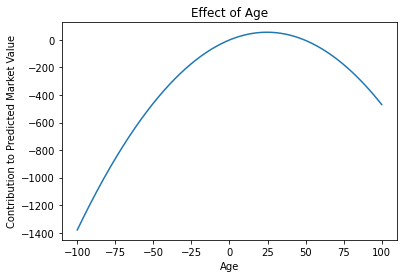

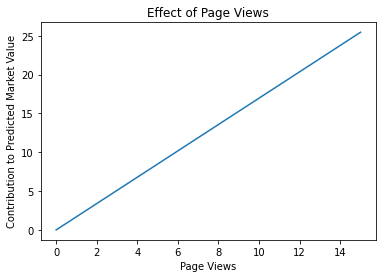

In [39]:
# Q2: let's use the age coefficients to show the effect of age has on one's market value;
# we can get the age and age^2 coefficients via:
agecoef = fitted_model_1.params.age
age2coef = fitted_model_1.params.age_squared

# let's set our x-axis (corresponding to age) to be a wide range from -100 to 100, 
# just to see a grand picture of the function
x_vals = np.linspace(-100,100,1000)
y_vals = agecoef*x_vals +age2coef*x_vals**2

# WRITE CODE TO PLOT x_vals vs y_vals
plt.plot(x_vals, y_vals)
plt.title("Effect of Age")
plt.xlabel("Age")
plt.ylabel("Contribution to Predicted Market Value")
plt.show()

# Q2A: WHAT HAPPENS IF WE USED ONLY AGE (not AGE^2) in our model (what's the r2?); make the same plot of age vs market value
# Q2B: WHAT HAPPENS IF WE USED ONLY AGE^2 (not age) in our model (what's the r2?); make the same plot of age^2 vs market value
# Q2C: PLOT page views vs market value

# SOLUTION
page_view_coef = fitted_model_1.params.log_views
x_vals = np.linspace(0,15)
y_vals = page_view_coef*x_vals
plt.plot(x_vals, y_vals)
plt.title("Effect of Page Views")
plt.xlabel("Page Views")
plt.ylabel("Contribution to Predicted Market Value")
plt.show()

# 3- Linear regression on non-experimental data can't determine causation, so we can't prove that
# a given relationship runs in the direction we might think. For instance, doing whatever it
# takes to get more page views probably doesn't meaningfully increase market value; it's likely
# the causation runs in the other direction and great players get more views. Even so, we can use
# page views to help us tell who is a great player and thus likely to be paid well.

<hr style='height:3px'>

### Part 3.3: Turning Categorical Variables into multiple binary variables
Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is probably between -0.5 to -1 (depending on your run).

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [40]:
train_design_recoded = pd.get_dummies(train_transformed, columns=['position_cat'], drop_first=True)
test_design_recoded = pd.get_dummies(test_transformed, columns=['position_cat'], drop_first=True)

train_design_recoded.head()

,const,fpl_points,age,age_squared,log_views,new_signing,big_club,position_cat_2,position_cat_3,position_cat_4
279,1.0,26,32,1024,9.870365,0,1,1,0,0
52,1.0,0,32,1024,6.686501,0,0,0,0,1
312,1.0,80,25,625,8.894818,0,0,1,0,0
57,1.0,0,36,1296,7.748193,0,0,0,0,0
151,1.0,31,27,729,7.857981,0,0,0,1,0


We've removed the original `position_cat` column and created three new ones.

#### Why only three new columns?
Why does pandas give us the option to drop the first category? 

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
2. Fit a model on the new, recoded data, then interpret the coefficient of `position_cat_2`.


In [41]:
### SOLUTION:
resu = OLS(y_train, train_design_recoded).fit()
resu.summary()
print("r2:", r2_score(y_test, resu.predict(test_design_recoded)))
print("position_cat_2 coef:", resu.params.position_cat_2)
train_design_recoded.shape, y_train.shape

r2: 0.6468080878333718
position_cat_2 coef: -1.7978920532876277


((368, 10), (368,))

**SOLUTION:**
1. If our model does not have a constant, we must include all four dummy variable columns. If we drop one, we're not modeling any effect of being in that category, and effectively assuming the dropped category's effect is 0.
2. Being in position 2 (instead of position 1) has an impact between -1.54 and +2.38 on a player's market value. Since we're using an intercept, the dropped category becomes the baseline and the effect of any dummy variable is the effect of being in that category instead of the baseline category.

## Part 4: A nice trick for forward-backwards

XOR (operator ^) is a logical operation that only returns true when input differ. We can use it to implement forward-or-backwards selection when we want to keep track of whet predictors are "left" from a given list of predictors.

The set analog is "symmetric difference". From the python docs:

`s.symmetric_difference(t)	s ^ t	new set with elements in either s or t but not both`


In [42]:
set() ^ set([1,2,3])

{1, 2, 3}

In [43]:
set([1]) ^ set([1,2,3])

{2, 3}

In [44]:
set([1, 2]) ^ set([1,2,3])

{3}

<div class="exercise"><b>Exercise</b></div>

Outline a step-forwards algorithm which uses this idea

**SOLUTION:**

Start with no predictors in a set, `selected_predictors`. Then the "xor" will give the set of all predictors. Go through them 1-by -1, seeing which has the highest score/ OR lowestaic/bic. Add this predictor to the `selected_predictors`.

Now repeat. The xor will eliminate this predictor from the remaining predictors. In the next iteration we will pick the next predictor which when combined with the first one gibes the lowest aic/bic of all 2-predictor models.

We repeat. We finally chose the best bic model from the 1 -predictor models, 2-predictor models, 3-predictor models and so on...

## BONUS EXERCISE:
We have provided a spreadsheet of Boston housing prices (data/boston_housing.csv). The 14 columns are as follows:
1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to ﬁve Boston employment centers
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per \$10,000
11. PTRATIO: pupil-teacher ratio by town
12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town
13. LSTAT: % lower status of the population
14. MEDV: Median value of owner-occupied homes in $1000s We can see that the input attributes have a mixture of units

There are 450 observations.
<div class="exercise"><b>Exercise</b></div>

Using the above file, try your best to predict **housing prices. (the 14th column)** We have provided a test set `data/boston_housing_test.csv` but refrain from looking at the file or evaluating on it until you have finalized and trained a model.
1. Load in the data. It is tab-delimited. Quickly look at a summary of the data to familiarize yourself with it and ensure nothing is too egregious.
2. Use a previously-discussed function to automatically partition the data into a training and validation (aka development) set. It is up to you to choose how large these two portions should be.
3. Train a basic model on just a subset of the features. What is the performance on the validation set?
4. Train a basic model on all of the features. What is the performance on the validation set?
5. Toy with the model until you feel your results are reasonably good.
6. Perform cross-validation with said model, and measure the average performance. Are the results what you expected? Were the average results better or worse than that from your original 1 validation set?
7. Experiment with other models, and for each, perform 10-fold cross-validation. Which model yields the best average performance? Select this as your final model.
8. Use this model to evaulate your performance on the testing set. What is your performance (MSE)? Is this what you expected?